# Unit 11: 決策樹回歸 (Decision Tree Regression)

**課程名稱**：AI 在化工上之應用  
**課程代碼**：CHE-AI-114  
**授課教師**：莊曜禎 助理教授  
**單元主題**：決策樹回歸模型  

---

## 學習目標

1. 使用 sklearn 建立決策樹回歸模型
2. 理解決策樹的超參數調整
3. 視覺化決策樹結構
4. 分析特徵重要性
5. 診斷與防止過擬合
6. 應用於化工製程優化

---

## 案例說明

**背景**：催化反應器生產某化學品，產率受溫度、壓力、催化劑用量影響。

**目標**：建立決策樹模型預測產率，並找出最佳操作條件。

**特徵**：
- Temperature (°C)：150-250
- Pressure (bar)：1-5
- Catalyst (g)：0.5-2.0

**目標變數**：Yield (%)：70-95

---
## 0. 環境設定

In [1]:
from pathlib import Path
import tensorflow as tf
import os

# ========================================
# 路徑設定 (兼容 Colab 與 Local)
# ========================================
UNIT_OUTPUT_DIR = 'P3_Unit11_Decision_Tree'
SOURCE_DATA_DIR = 'decision_tree'

try:
  from google.colab import drive
  IN_COLAB = True
  print("✓ 偵測到 Colab 環境，準備掛載 Google Drive...")
  drive.mount('/content/drive', force_remount=True)
except ImportError:
  IN_COLAB = False
  print("✓ 偵測到 Local 環境")
try:
  shortcut_path = '/content/CHE-AI-COURSE'
  os.remove(shortcut_path)
except FileNotFoundError:
  pass

if IN_COLAB:
  source_path = Path('/content/drive/My Drive/Colab Notebooks/CHE-AI-COURSE')
  os.symlink(source_path, shortcut_path)
  shortcut_path = Path(shortcut_path)
  if source_path.exists():
    NOTEBOOK_DIR = shortcut_path / 'Part_3' / 'Unit11'
    OUTPUT_DIR = NOTEBOOK_DIR / 'outputs' / UNIT_OUTPUT_DIR
    DATA_DIR = NOTEBOOK_DIR / 'data' / SOURCE_DATA_DIR
    MODEL_DIR = OUTPUT_DIR / 'models'
    FIG_DIR = OUTPUT_DIR / 'figs'
  else:
    print(f"⚠️ 找不到路徑雲端CHE-AI-COURSE路徑，請確認自己的雲端資料夾是否正確")
  
else:
  NOTEBOOK_DIR = Path.cwd()
  OUTPUT_DIR = NOTEBOOK_DIR / 'outputs' / UNIT_OUTPUT_DIR
  DATA_DIR = NOTEBOOK_DIR / 'data' / SOURCE_DATA_DIR
  MODEL_DIR = OUTPUT_DIR / 'models'
  FIG_DIR = OUTPUT_DIR / 'figs'

NOTEBOOK_DIR.mkdir(parents=True, exist_ok=True)
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
DATA_DIR.mkdir(parents=True, exist_ok=True)
MODEL_DIR.mkdir(parents=True, exist_ok=True)
FIG_DIR.mkdir(parents=True, exist_ok=True)

print(f"\n✓ Notebook工作目錄: {NOTEBOOK_DIR}")
print(f"✓ 數據來源目錄: {DATA_DIR}")
print(f"✓ 結果輸出目錄: {OUTPUT_DIR}")
print(f"✓ 模型輸出目錄: {MODEL_DIR}")
print(f"✓ 圖檔輸出目錄: {FIG_DIR}")


# ========================================
# 檢查 GPU 狀態
# ========================================
print(f"\nTensorFlow Version: {tf.__version__}")
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"✓ 偵測到 GPU：{gpus[0].name}")
    print("  （訓練速度將明顯快於僅用 CPU）")
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
else:
    print("△ 未偵測到 GPU。")
    print("  訓練速度將使用 CPU（速度較慢但仍可完成）")

✓ 偵測到 Local 環境

✓ Notebook工作目錄: d:\MyGit\CHE-AI-COURSE\Part_3\Unit11
✓ 數據來源目錄: d:\MyGit\CHE-AI-COURSE\Part_3\Unit11\data\decision_tree
✓ 結果輸出目錄: d:\MyGit\CHE-AI-COURSE\Part_3\Unit11\outputs\P3_Unit11_Decision_Tree
✓ 模型輸出目錄: d:\MyGit\CHE-AI-COURSE\Part_3\Unit11\outputs\P3_Unit11_Decision_Tree\models
✓ 圖檔輸出目錄: d:\MyGit\CHE-AI-COURSE\Part_3\Unit11\outputs\P3_Unit11_Decision_Tree\figs

TensorFlow Version: 2.10.1
✓ 偵測到 GPU：/physical_device:GPU:0
  （訓練速度將明顯快於僅用 CPU）


---
## 1. 載入相關套件

In [2]:
# 基礎套件
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# 機器學習套件
from sklearn.tree import DecisionTreeRegressor, plot_tree, export_text
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, learning_curve
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# 設定隨機種子以確保結果可重現
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# 設定matplotlib中文顯示
plt.rcParams['axes.unicode_minus'] = False

print("✓ 所有套件已成功載入！")

✓ 所有套件已成功載入！


---
## 2. 資料生成（模擬實驗數據）

In [3]:
# 設定參數
n_samples = 100

# 生成特徵
temperature = np.random.uniform(150, 250, n_samples)
pressure = np.random.uniform(1, 5, n_samples)
catalyst = np.random.uniform(0.5, 2.0, n_samples)

# 複雜的非線性關係（決策樹能捕捉）
# 調整公式，使數據更自然地分布在 70-95 範圍內

# 基礎效應：溫度和壓力的組合效應（改用更溫和的公式）
temp_normalized = (temperature - 150) / 100  # 0-1 範圍
pressure_normalized = (pressure - 1) / 4     # 0-1 範圍
catalyst_normalized = (catalyst - 0.5) / 1.5 # 0-1 範圍

# 基礎產率：使用 sigmoid 型函數避免超出範圍
yield_base = 72 + 15 * temp_normalized + 8 * pressure_normalized

# 溫度過高會降低產率（拋物線效應）
temp_penalty = -5 * (temp_normalized - 0.6) ** 2 * (temp_normalized > 0.6)

# 交互作用：適當溫度範圍內催化劑效果顯著
interaction_effect = 3 * catalyst_normalized * (temp_normalized > 0.4) * (temp_normalized < 0.8)

# 壓力和催化劑的協同效應
synergy_effect = 2.5 * pressure_normalized * catalyst_normalized

# 閾值效應：高壓且催化劑充足時的額外增益
threshold_effect = 2 * (pressure > 3.5).astype(int) * (catalyst > 1.5).astype(int)

# 加入噪聲
noise = np.random.normal(0, 1.5, n_samples)

# 最終產率（較少會超出範圍）
yield_value = yield_base + temp_penalty + interaction_effect + synergy_effect + threshold_effect + noise
yield_value = np.clip(yield_value, 70, 95)

# 建立 DataFrame
data = pd.DataFrame({
    'Temperature': temperature,
    'Pressure': pressure,
    'Catalyst': catalyst,
    'Yield': yield_value
})

print("資料生成完成！")
print(f"資料形狀：{data.shape}")
print(f"\n資料概覽：")
print(data.head())
print(f"\n資料統計：")
print(data.describe())
print(f"\n產率分布檢查：")
print(f"  達到上限 (95%) 的樣本數：{(data['Yield'] >= 94.9).sum()} ({(data['Yield'] >= 94.9).sum()/len(data)*100:.1f}%)")
print(f"  達到下限 (70%) 的樣本數：{(data['Yield'] <= 70.1).sum()} ({(data['Yield'] <= 70.1).sum()/len(data)*100:.1f}%)")

資料生成完成！
資料形狀：(100, 4)

資料概覽：
   Temperature  Pressure  Catalyst      Yield
0   187.454012  1.125717  1.463047  77.988339
1   245.071431  3.545642  0.626210  89.893464
2   223.199394  2.257424  0.742443  89.235470
3   209.865848  3.034283  1.847831  89.837430
4   165.601864  4.630266  1.409644  79.939034

資料統計：
       Temperature    Pressure    Catalyst       Yield
count   100.000000  100.000000  100.000000  100.000000
mean    197.018074    2.991327    1.276402   84.431842
std      29.748941    1.172445    0.440139    5.747166
min     150.552212    1.027809    0.507592   72.237614
25%     169.320076    1.968018    0.915320   80.188324
50%     196.414245    3.022499    1.343832   84.752008
75%     223.020312    4.064734    1.628550   88.587957
max     248.688694    4.942602    1.985081   95.000000

產率分布檢查：
  達到上限 (95%) 的樣本數：5 (5.0%)
  達到下限 (70%) 的樣本數：0 (0.0%)


## 3. 探索性資料分析 (EDA)

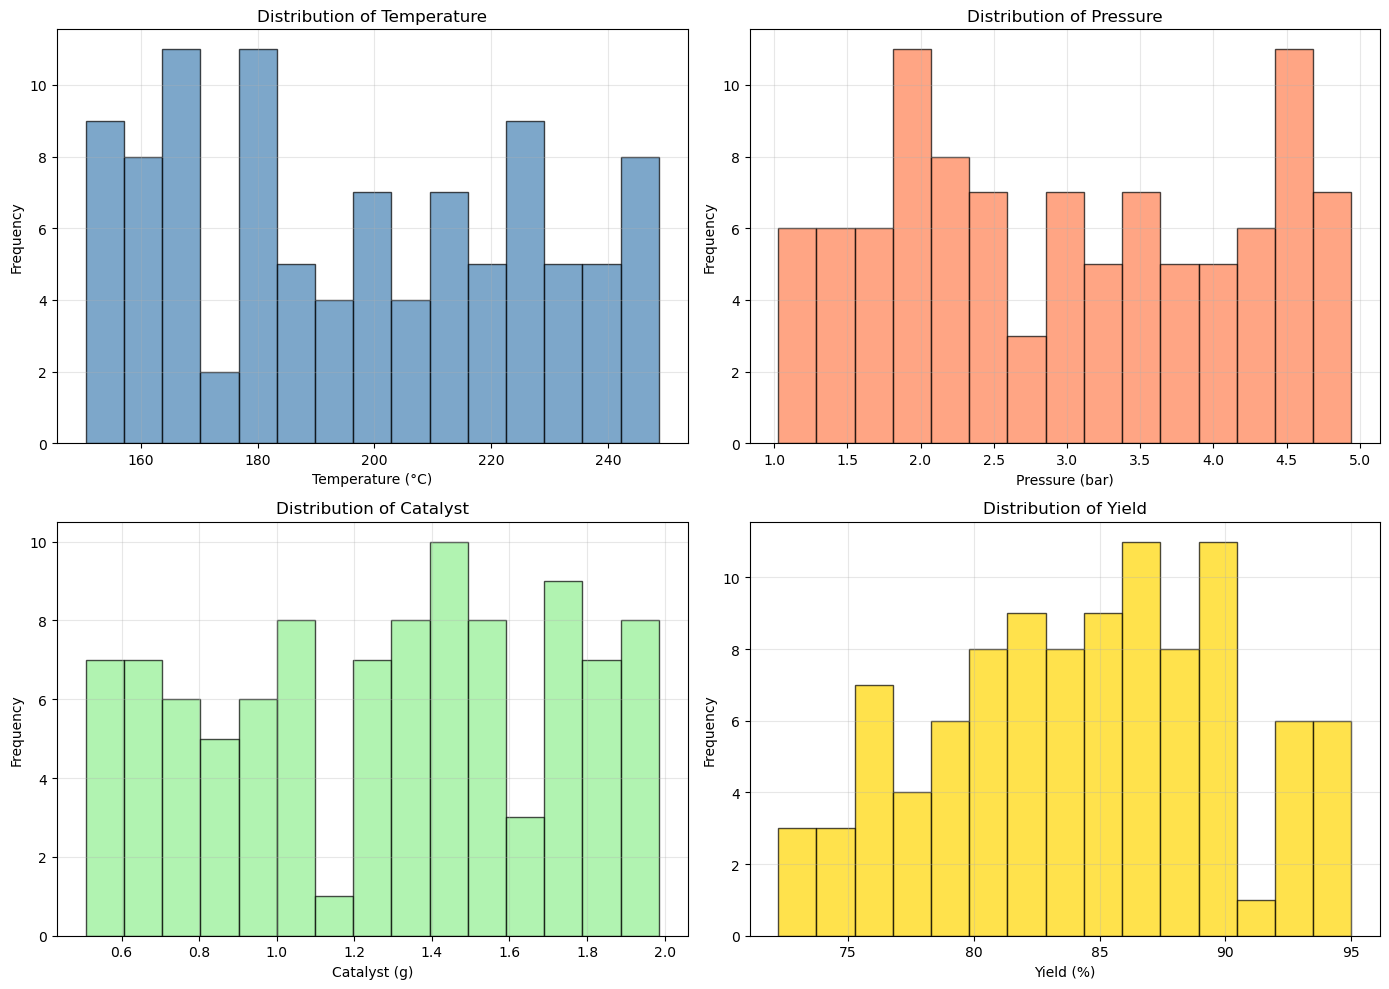

圖 1：特徵分佈圖已儲存


In [4]:
# 3.1 特徵分佈視覺化
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Temperature 分佈
axes[0, 0].hist(data['Temperature'], bins=15, edgecolor='black', alpha=0.7, color='steelblue')
axes[0, 0].set_xlabel('Temperature (°C)')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('Distribution of Temperature')
axes[0, 0].grid(True, alpha=0.3)

# Pressure 分佈
axes[0, 1].hist(data['Pressure'], bins=15, edgecolor='black', alpha=0.7, color='coral')
axes[0, 1].set_xlabel('Pressure (bar)')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_title('Distribution of Pressure')
axes[0, 1].grid(True, alpha=0.3)

# Catalyst 分佈
axes[1, 0].hist(data['Catalyst'], bins=15, edgecolor='black', alpha=0.7, color='lightgreen')
axes[1, 0].set_xlabel('Catalyst (g)')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].set_title('Distribution of Catalyst')
axes[1, 0].grid(True, alpha=0.3)

# Yield 分佈
axes[1, 1].hist(data['Yield'], bins=15, edgecolor='black', alpha=0.7, color='gold')
axes[1, 1].set_xlabel('Yield (%)')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].set_title('Distribution of Yield')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(FIG_DIR / '01_feature_distributions.png', dpi=300, bbox_inches='tight')
plt.show()

print("圖 1：特徵分佈圖已儲存")

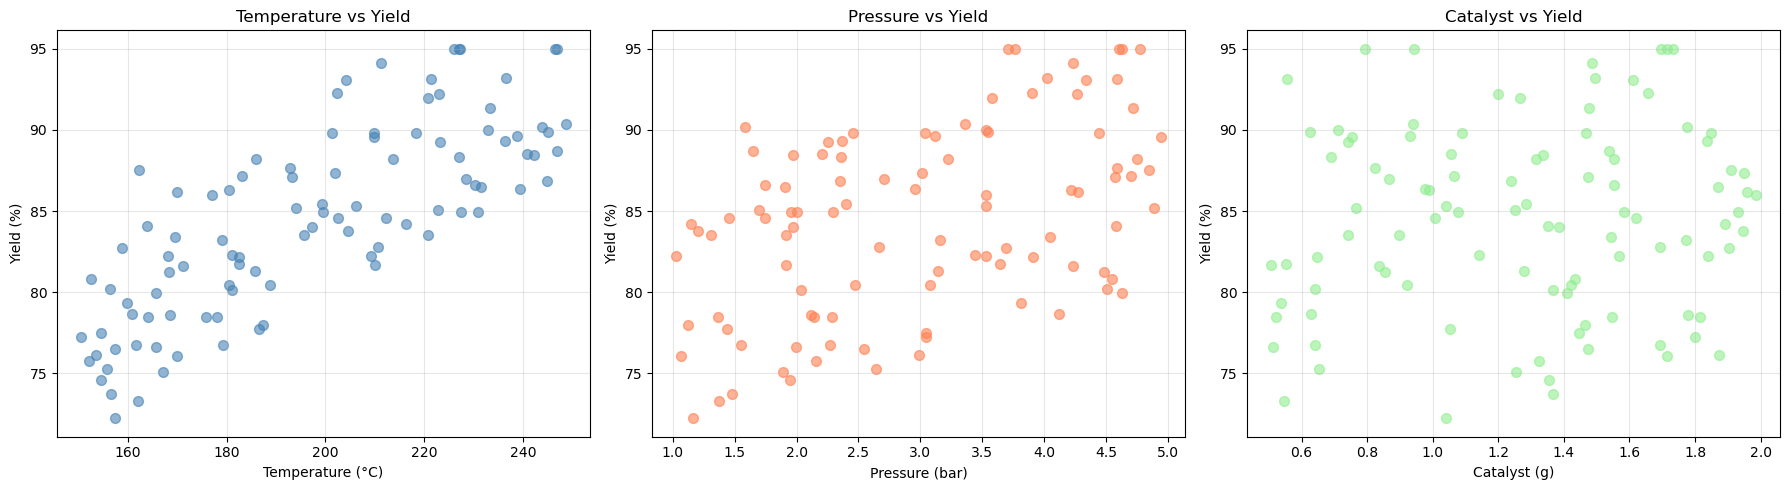

圖 2：特徵與產率關係圖已儲存


In [5]:
# 3.2 特徵與目標變數的關係
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Temperature vs Yield
axes[0].scatter(data['Temperature'], data['Yield'], alpha=0.6, s=50, color='steelblue')
axes[0].set_xlabel('Temperature (°C)')
axes[0].set_ylabel('Yield (%)')
axes[0].set_title('Temperature vs Yield')
axes[0].grid(True, alpha=0.3)

# Pressure vs Yield
axes[1].scatter(data['Pressure'], data['Yield'], alpha=0.6, s=50, color='coral')
axes[1].set_xlabel('Pressure (bar)')
axes[1].set_ylabel('Yield (%)')
axes[1].set_title('Pressure vs Yield')
axes[1].grid(True, alpha=0.3)

# Catalyst vs Yield
axes[2].scatter(data['Catalyst'], data['Yield'], alpha=0.6, s=50, color='lightgreen')
axes[2].set_xlabel('Catalyst (g)')
axes[2].set_ylabel('Yield (%)')
axes[2].set_title('Catalyst vs Yield')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(FIG_DIR / '02_feature_vs_yield.png', dpi=300, bbox_inches='tight')
plt.show()

print("圖 2：特徵與產率關係圖已儲存")

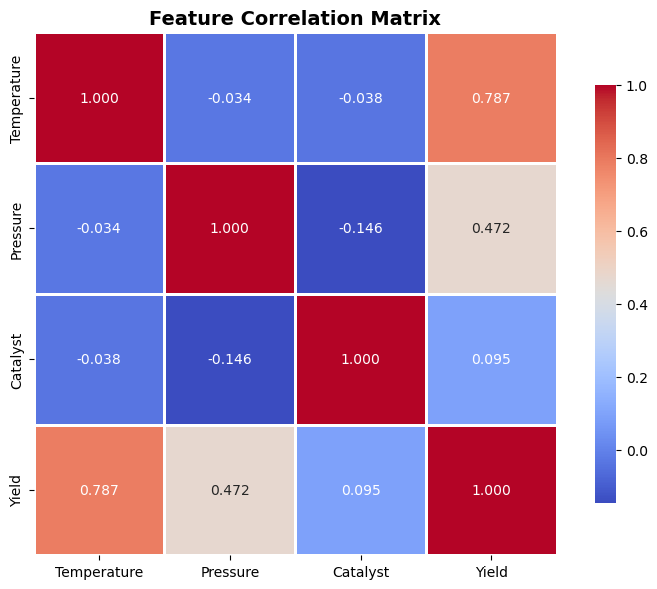

圖 3：相關性矩陣已儲存

相關性係數：
Yield          1.000000
Temperature    0.786752
Pressure       0.471568
Catalyst       0.095101
Name: Yield, dtype: float64


In [6]:
# 3.3 相關性分析
correlation_matrix = data.corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, fmt='.3f', cmap='coolwarm', 
            square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Feature Correlation Matrix', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(FIG_DIR / '03_correlation_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

print("圖 3：相關性矩陣已儲存")
print(f"\n相關性係數：")
print(correlation_matrix['Yield'].sort_values(ascending=False))

## 4. 資料分割

In [7]:
# 準備特徵和目標變數
X = data[['Temperature', 'Pressure', 'Catalyst']].values
y = data['Yield'].values

# 分割訓練集和測試集（70/30）
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=RANDOM_STATE
)

print("資料分割完成！")
print(f"訓練集樣本數：{len(X_train)} ({len(X_train)/len(X)*100:.1f}%)")
print(f"測試集樣本數：{len(X_test)} ({len(X_test)/len(X)*100:.1f}%)")
print(f"\n訓練集 Y 統計：")
print(f"  平均值：{y_train.mean():.2f}")
print(f"  標準差：{y_train.std():.2f}")
print(f"  範圍：[{y_train.min():.2f}, {y_train.max():.2f}]")

資料分割完成！
訓練集樣本數：70 (70.0%)
測試集樣本數：30 (30.0%)

訓練集 Y 統計：
  平均值：84.67
  標準差：5.53
  範圍：[72.24, 95.00]


## 5. 模型 A：無限制決策樹（展示過擬合）

In [8]:
# 建立無限制的決策樹
tree_unrestricted = DecisionTreeRegressor(random_state=RANDOM_STATE)

# 訓練模型
tree_unrestricted.fit(X_train, y_train)

# 預測
y_pred_train_unrestricted = tree_unrestricted.predict(X_train)
y_pred_test_unrestricted = tree_unrestricted.predict(X_test)

# 評估
train_r2_unrestricted = r2_score(y_train, y_pred_train_unrestricted)
test_r2_unrestricted = r2_score(y_test, y_pred_test_unrestricted)
train_rmse_unrestricted = np.sqrt(mean_squared_error(y_train, y_pred_train_unrestricted))
test_rmse_unrestricted = np.sqrt(mean_squared_error(y_test, y_pred_test_unrestricted))

print("=" * 50)
print("模型 A：無限制決策樹（max_depth=None）")
print("=" * 50)
print(f"樹深度：{tree_unrestricted.get_depth()}")
print(f"葉節點數：{tree_unrestricted.get_n_leaves()}")
print(f"\n訓練集性能：")
print(f"  R² = {train_r2_unrestricted:.4f}")
print(f"  RMSE = {train_rmse_unrestricted:.2f}")
print(f"\n測試集性能：")
print(f"  R² = {test_r2_unrestricted:.4f}")
print(f"  RMSE = {test_rmse_unrestricted:.2f}")
print(f"\n⚠️  R² 差距：{train_r2_unrestricted - test_r2_unrestricted:.4f} → 過擬合跡象！")

模型 A：無限制決策樹（max_depth=None）
樹深度：11
葉節點數：68

訓練集性能：
  R² = 1.0000
  RMSE = 0.00

測試集性能：
  R² = 0.9013
  RMSE = 1.92

⚠️  R² 差距：0.0987 → 過擬合跡象！


## 6. 模型 B：受控決策樹（設定深度限制）

In [9]:
# 建立受控的決策樹
tree_controlled = DecisionTreeRegressor(
    max_depth=5,
    min_samples_split=10,
    min_samples_leaf=5,
    random_state=RANDOM_STATE
)

# 訓練模型
tree_controlled.fit(X_train, y_train)

# 預測
y_pred_train_controlled = tree_controlled.predict(X_train)
y_pred_test_controlled = tree_controlled.predict(X_test)

# 評估
train_r2_controlled = r2_score(y_train, y_pred_train_controlled)
test_r2_controlled = r2_score(y_test, y_pred_test_controlled)
train_rmse_controlled = np.sqrt(mean_squared_error(y_train, y_pred_train_controlled))
test_rmse_controlled = np.sqrt(mean_squared_error(y_test, y_pred_test_controlled))

print("=" * 50)
print("模型 B：受控決策樹（max_depth=5）")
print("=" * 50)
print(f"樹深度：{tree_controlled.get_depth()}")
print(f"葉節點數：{tree_controlled.get_n_leaves()}")
print(f"\n訓練集性能：")
print(f"  R² = {train_r2_controlled:.4f}")
print(f"  RMSE = {train_rmse_controlled:.2f}")
print(f"\n測試集性能：")
print(f"  R² = {test_r2_controlled:.4f}")
print(f"  RMSE = {test_rmse_controlled:.2f}")
print(f"\n✓ R² 差距：{train_r2_controlled - test_r2_controlled:.4f} → 泛化能力良好！")

模型 B：受控決策樹（max_depth=5）
樹深度：4
葉節點數：11

訓練集性能：
  R² = 0.9019
  RMSE = 1.73

測試集性能：
  R² = 0.7977
  RMSE = 2.75

✓ R² 差距：0.1042 → 泛化能力良好！


In [10]:
# 比較兩個模型
comparison = pd.DataFrame({
    'Model': ['Unrestricted Tree', 'Controlled Tree'],
    'Max Depth': [tree_unrestricted.get_depth(), tree_controlled.get_depth()],
    'Leaf Nodes': [tree_unrestricted.get_n_leaves(), tree_controlled.get_n_leaves()],
    'Train R²': [train_r2_unrestricted, train_r2_controlled],
    'Test R²': [test_r2_unrestricted, test_r2_controlled],
    'Train RMSE': [train_rmse_unrestricted, train_rmse_controlled],
    'Test RMSE': [test_rmse_unrestricted, test_rmse_controlled]
})

print("\n" + "=" * 80)
print("模型比較")
print("=" * 80)
print(comparison.to_string(index=False))

# 儲存結果
comparison.to_csv(OUTPUT_DIR / 'model_comparison.csv', index=False)
print(f"\n結果已儲存至：{OUTPUT_DIR / 'model_comparison.csv'}")


模型比較
            Model  Max Depth  Leaf Nodes  Train R²  Test R²  Train RMSE  Test RMSE
Unrestricted Tree         11          68  1.000000 0.901251    0.000000   1.918326
  Controlled Tree          4          11  0.901939 0.797704    1.731062   2.745673

結果已儲存至：d:\MyGit\CHE-AI-COURSE\Part_3\Unit11\outputs\P3_Unit11_Decision_Tree\model_comparison.csv


## 7. 超參數調整（網格搜尋）

In [11]:
# 定義超參數網格
param_grid = {
    'max_depth': [3, 5, 7, 10, None],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 5, 10]
}

# 建立網格搜尋
grid_search = GridSearchCV(
    DecisionTreeRegressor(random_state=RANDOM_STATE),
    param_grid,
    cv=5,
    scoring='r2',
    n_jobs=-1,
    verbose=1
)

print("開始網格搜尋...")
print(f"總共測試 {len(param_grid['max_depth']) * len(param_grid['min_samples_split']) * len(param_grid['min_samples_leaf'])} 種組合")
print("="*50)

# 執行網格搜尋
grid_search.fit(X_train, y_train)

print("\n網格搜尋完成！")
print(f"\n最佳參數：")
for param, value in grid_search.best_params_.items():
    print(f"  {param}: {value}")
print(f"\n最佳 CV R²：{grid_search.best_score_:.4f}")

開始網格搜尋...
總共測試 80 種組合
Fitting 5 folds for each of 80 candidates, totalling 400 fits

網格搜尋完成！

最佳參數：
  max_depth: 7
  min_samples_leaf: 2
  min_samples_split: 2

最佳 CV R²：0.7332


In [12]:
# 使用最佳參數訓練最終模型
best_tree = grid_search.best_estimator_

# 預測
y_pred_train_best = best_tree.predict(X_train)
y_pred_test_best = best_tree.predict(X_test)

# 評估
train_r2_best = r2_score(y_train, y_pred_train_best)
test_r2_best = r2_score(y_test, y_pred_test_best)
train_rmse_best = np.sqrt(mean_squared_error(y_train, y_pred_train_best))
test_rmse_best = np.sqrt(mean_squared_error(y_test, y_pred_test_best))
test_mae_best = mean_absolute_error(y_test, y_pred_test_best)

print("=" * 50)
print("最佳決策樹模型性能")
print("=" * 50)
print(f"樹深度：{best_tree.get_depth()}")
print(f"葉節點數：{best_tree.get_n_leaves()}")
print(f"\n訓練集性能：")
print(f"  R² = {train_r2_best:.4f}")
print(f"  RMSE = {train_rmse_best:.2f}")
print(f"\n測試集性能：")
print(f"  R² = {test_r2_best:.4f}")
print(f"  RMSE = {test_rmse_best:.2f}")
print(f"  MAE = {test_mae_best:.2f}")

最佳決策樹模型性能
樹深度：7
葉節點數：30

訓練集性能：
  R² = 0.9736
  RMSE = 0.90

測試集性能：
  R² = 0.8759
  RMSE = 2.15
  MAE = 1.73


## 8. 特徵重要性分析

特徵重要性排名：
    Feature  Importance
Temperature    0.632348
   Pressure    0.339227
   Catalyst    0.028426


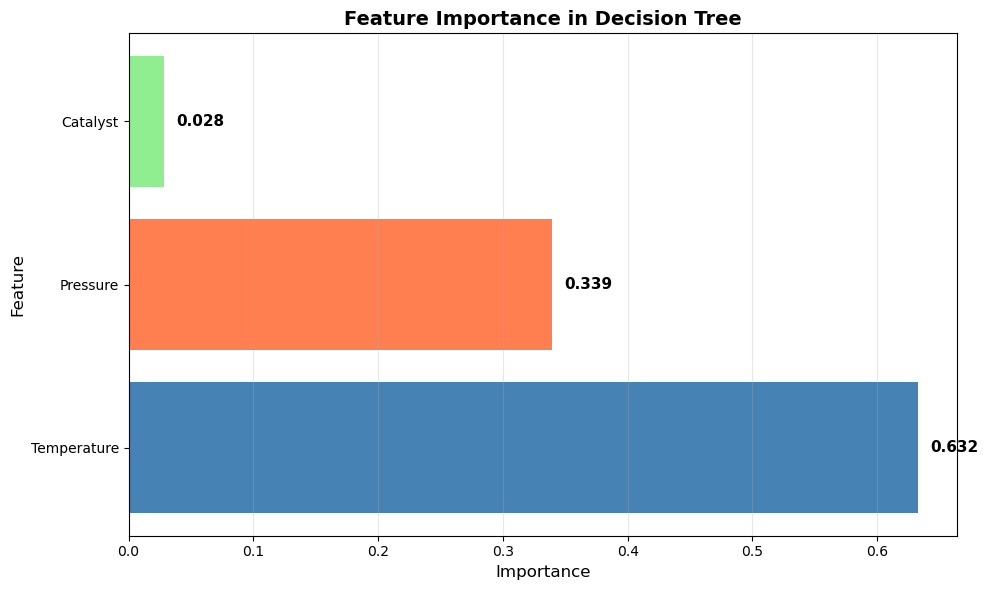


圖 4：特徵重要性圖已儲存


In [13]:
# 取得特徵重要性
feature_names = ['Temperature', 'Pressure', 'Catalyst']
importances = best_tree.feature_importances_

# 建立 DataFrame
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values('Importance', ascending=False)

print("特徵重要性排名：")
print(feature_importance_df.to_string(index=False))

# 視覺化
plt.figure(figsize=(10, 6))
colors = ['steelblue', 'coral', 'lightgreen']
bars = plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color=colors)
plt.xlabel('Importance', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.title('Feature Importance in Decision Tree', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3, axis='x')

# 標註數值
for bar, imp in zip(bars, feature_importance_df['Importance']):
    plt.text(imp + 0.01, bar.get_y() + bar.get_height()/2, f'{imp:.3f}', 
             va='center', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.savefig(FIG_DIR / '04_feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n圖 4：特徵重要性圖已儲存")

# 儲存結果
feature_importance_df.to_csv(OUTPUT_DIR / 'feature_importance.csv', index=False)

## 9. 決策樹結構視覺化

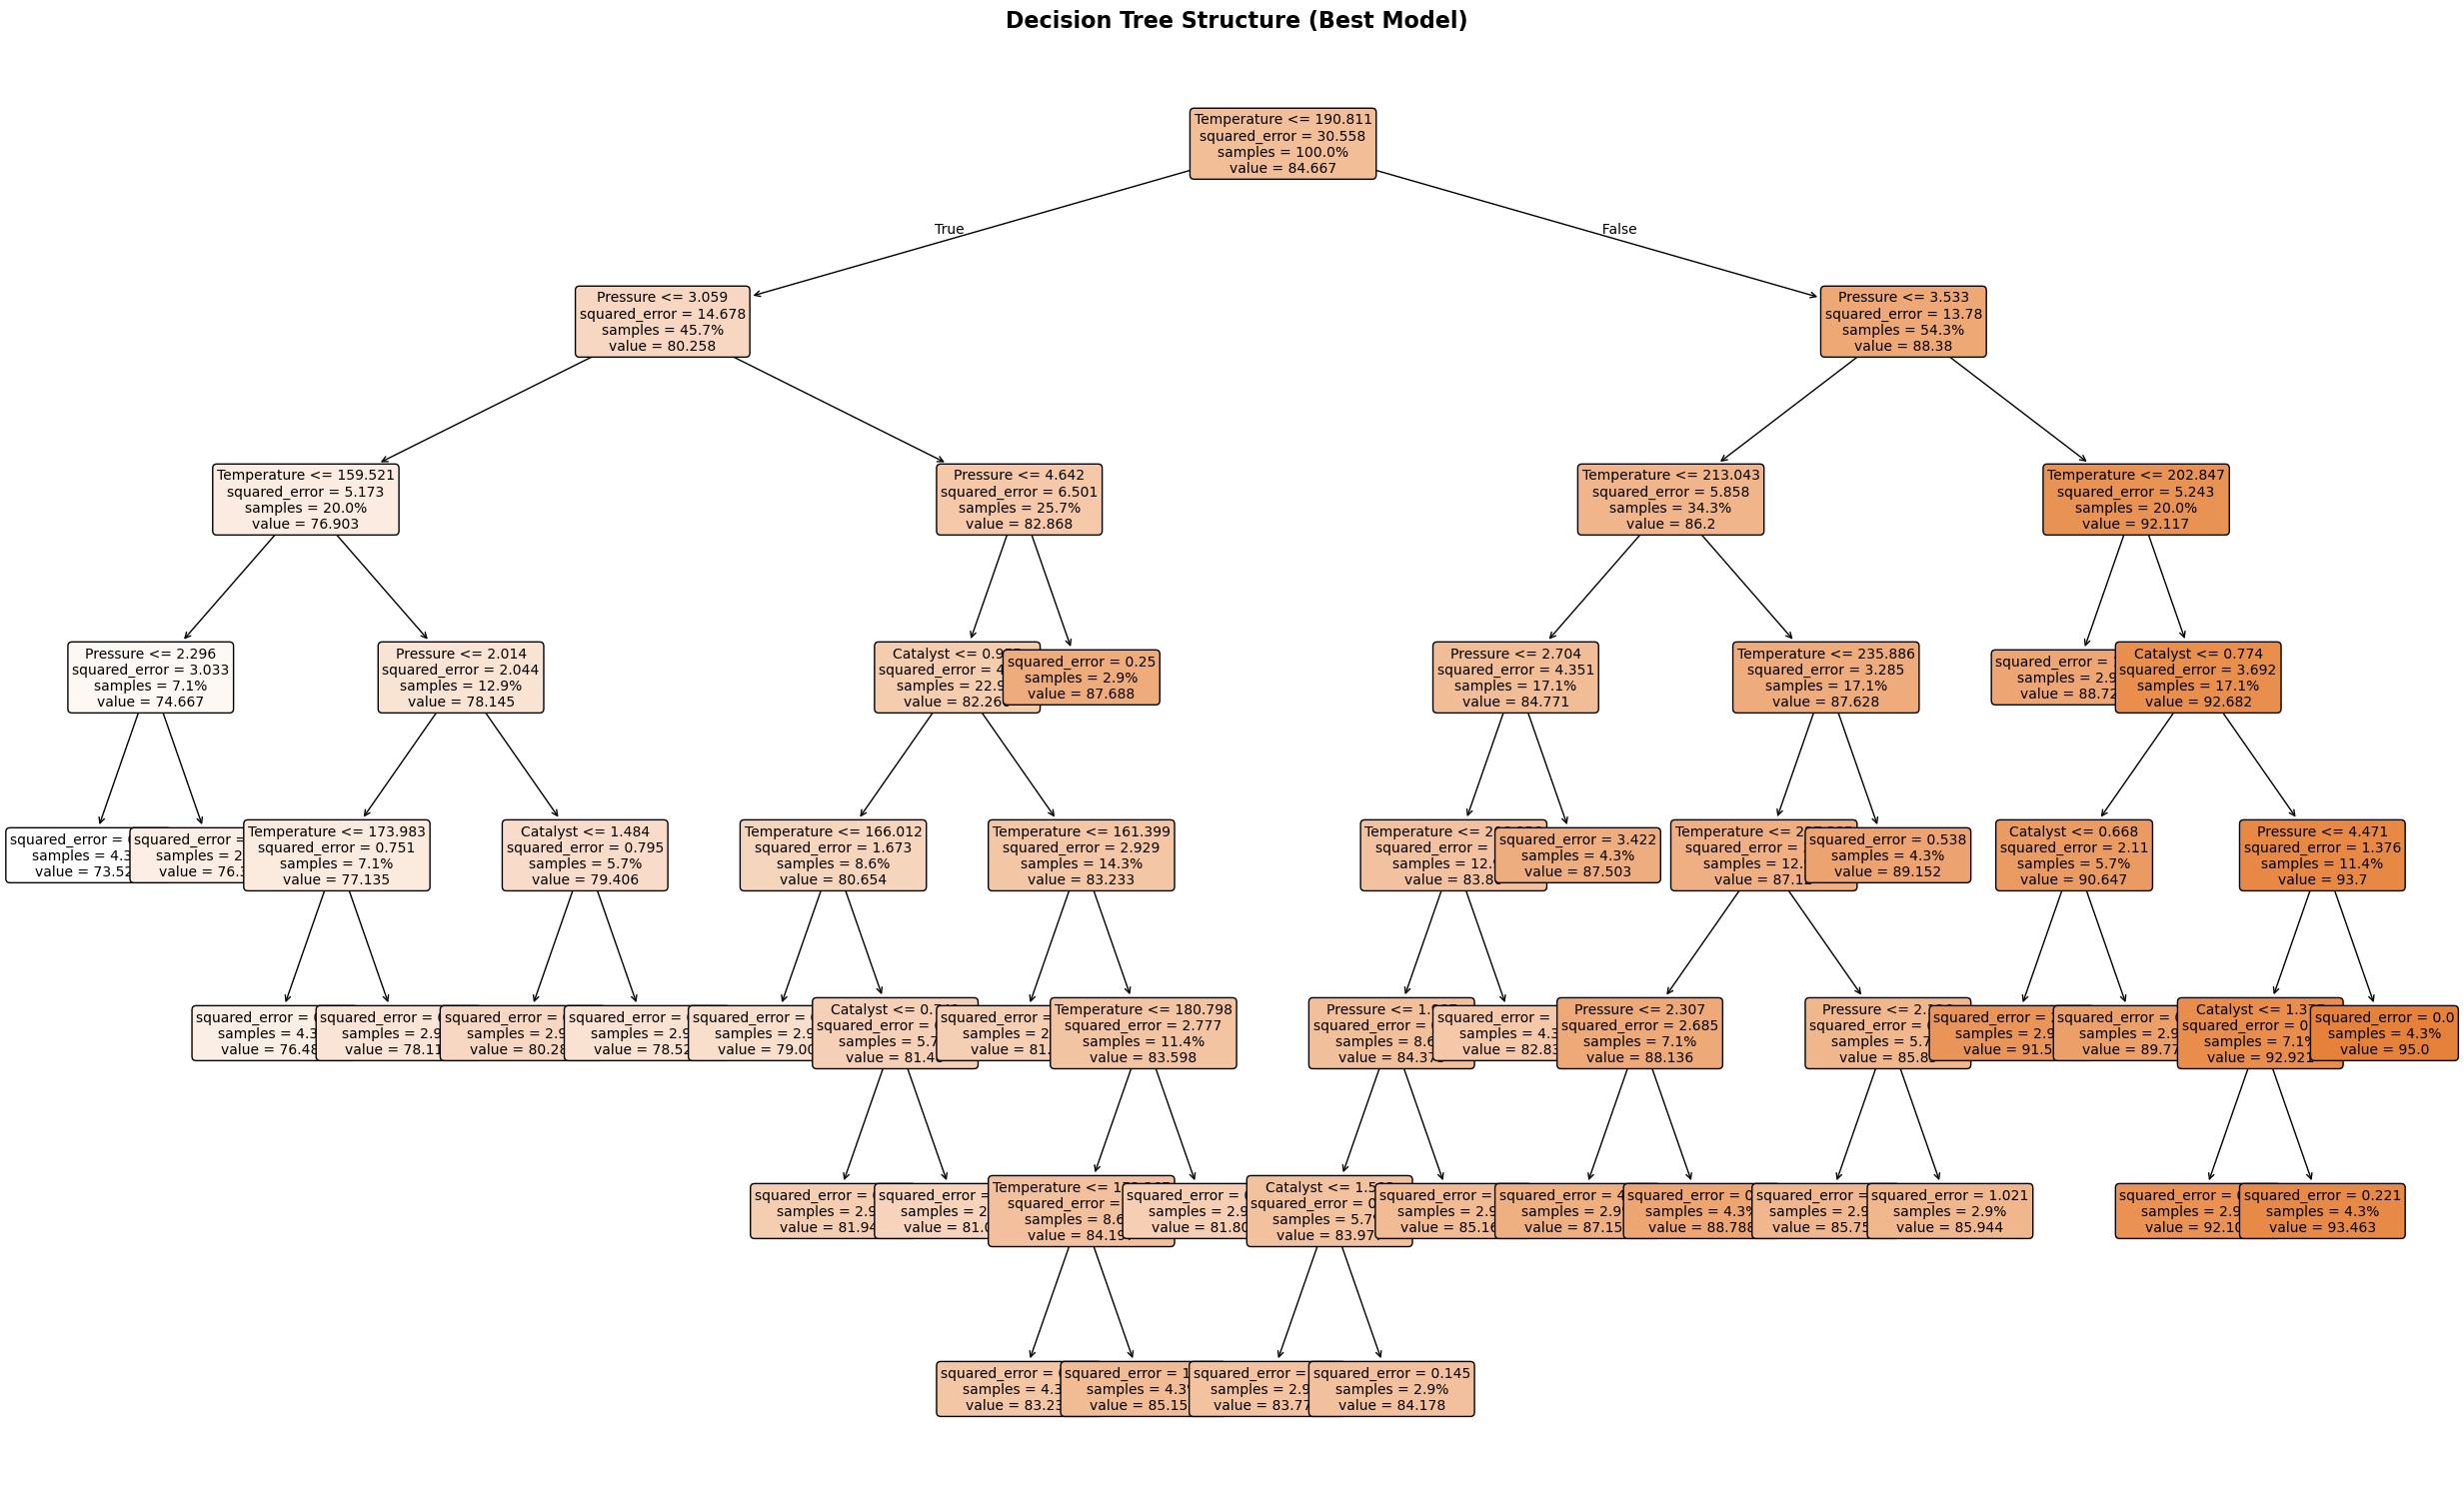

圖 5：決策樹結構圖已儲存


In [14]:
# 視覺化決策樹結構
plt.figure(figsize=(25, 15))
plot_tree(
    best_tree,
    feature_names=feature_names,
    filled=True,
    rounded=True,
    fontsize=10,
    proportion=True
)
plt.title('Decision Tree Structure (Best Model)', fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig(FIG_DIR / '05_tree_structure.png', dpi=300, bbox_inches='tight')
plt.show()

print("圖 5：決策樹結構圖已儲存")

In [15]:
# 匯出決策規則（文字格式）
tree_rules = export_text(best_tree, feature_names=feature_names)

print("決策樹規則：")
print("=" * 80)
print(tree_rules)

# 儲存規則
with open(OUTPUT_DIR / 'tree_rules.txt', 'w', encoding='utf-8') as f:
    f.write(tree_rules)

print(f"\n決策規則已儲存至：{OUTPUT_DIR / 'tree_rules.txt'}")

決策樹規則：
|--- Temperature <= 190.81
|   |--- Pressure <= 3.06
|   |   |--- Temperature <= 159.52
|   |   |   |--- Pressure <= 2.30
|   |   |   |   |--- value: [73.52]
|   |   |   |--- Pressure >  2.30
|   |   |   |   |--- value: [76.38]
|   |   |--- Temperature >  159.52
|   |   |   |--- Pressure <= 2.01
|   |   |   |   |--- Temperature <= 173.98
|   |   |   |   |   |--- value: [76.48]
|   |   |   |   |--- Temperature >  173.98
|   |   |   |   |   |--- value: [78.12]
|   |   |   |--- Pressure >  2.01
|   |   |   |   |--- Catalyst <= 1.48
|   |   |   |   |   |--- value: [80.29]
|   |   |   |   |--- Catalyst >  1.48
|   |   |   |   |   |--- value: [78.52]
|   |--- Pressure >  3.06
|   |   |--- Pressure <= 4.64
|   |   |   |--- Catalyst <= 0.95
|   |   |   |   |--- Temperature <= 166.01
|   |   |   |   |   |--- value: [79.00]
|   |   |   |   |--- Temperature >  166.01
|   |   |   |   |   |--- Catalyst <= 0.74
|   |   |   |   |   |   |--- value: [81.95]
|   |   |   |   |   |--- Catalyst >  0

## 10. 預測與應用

In [16]:
# 預測特定操作條件下的產率
new_conditions = np.array([
    [180, 2.5, 1.0],   # 條件 1：低溫、中壓、中催化劑
    [200, 3.5, 1.5],   # 條件 2：中溫、高壓、高催化劑
    [220, 4.0, 1.8],   # 條件 3：高溫、高壓、高催化劑
    [170, 1.5, 0.8],   # 條件 4：低溫、低壓、低催化劑
    [230, 4.5, 2.0]    # 條件 5：極高溫、極高壓、最高催化劑
])

predictions = best_tree.predict(new_conditions)

print("不同操作條件下的產率預測：")
print("=" * 80)
for i, (cond, pred) in enumerate(zip(new_conditions, predictions), 1):
    print(f"條件 {i}: Temperature={cond[0]:.0f}°C, Pressure={cond[1]:.1f} bar, Catalyst={cond[2]:.1f} g")
    print(f"  → 預測產率：{pred:.2f}%\n")

不同操作條件下的產率預測：
條件 1: Temperature=180°C, Pressure=2.5 bar, Catalyst=1.0 g
  → 預測產率：80.29%

條件 2: Temperature=200°C, Pressure=3.5 bar, Catalyst=1.5 g
  → 預測產率：87.50%

條件 3: Temperature=220°C, Pressure=4.0 bar, Catalyst=1.8 g
  → 預測產率：93.46%

條件 4: Temperature=170°C, Pressure=1.5 bar, Catalyst=0.8 g
  → 預測產率：76.48%

條件 5: Temperature=230°C, Pressure=4.5 bar, Catalyst=2.0 g
  → 預測產率：95.00%



In [17]:
# 尋找最佳操作條件（網格搜尋）
print("尋找最佳操作條件...")
print("="*50)

# 建立網格
temp_range = np.linspace(150, 250, 50)
pressure_range = np.linspace(1, 5, 50)
catalyst_range = np.linspace(0.5, 2.0, 50)

# 儲存最佳結果
best_yield = 0
best_condition = None

# 固定催化劑，搜尋溫度和壓力
for catalyst in catalyst_range:
    for temp in temp_range:
        for press in pressure_range:
            condition = np.array([[temp, press, catalyst]])
            pred_yield = best_tree.predict(condition)[0]
            
            if pred_yield > best_yield:
                best_yield = pred_yield
                best_condition = [temp, press, catalyst]

print(f"最佳操作條件：")
print(f"  溫度：{best_condition[0]:.2f}°C")
print(f"  壓力：{best_condition[1]:.2f} bar")
print(f"  催化劑：{best_condition[2]:.2f} g")
print(f"\n預測最大產率：{best_yield:.2f}%")

尋找最佳操作條件...
最佳操作條件：
  溫度：203.06°C
  壓力：4.51 bar
  催化劑：0.78 g

預測最大產率：95.00%


## 11. 模型診斷

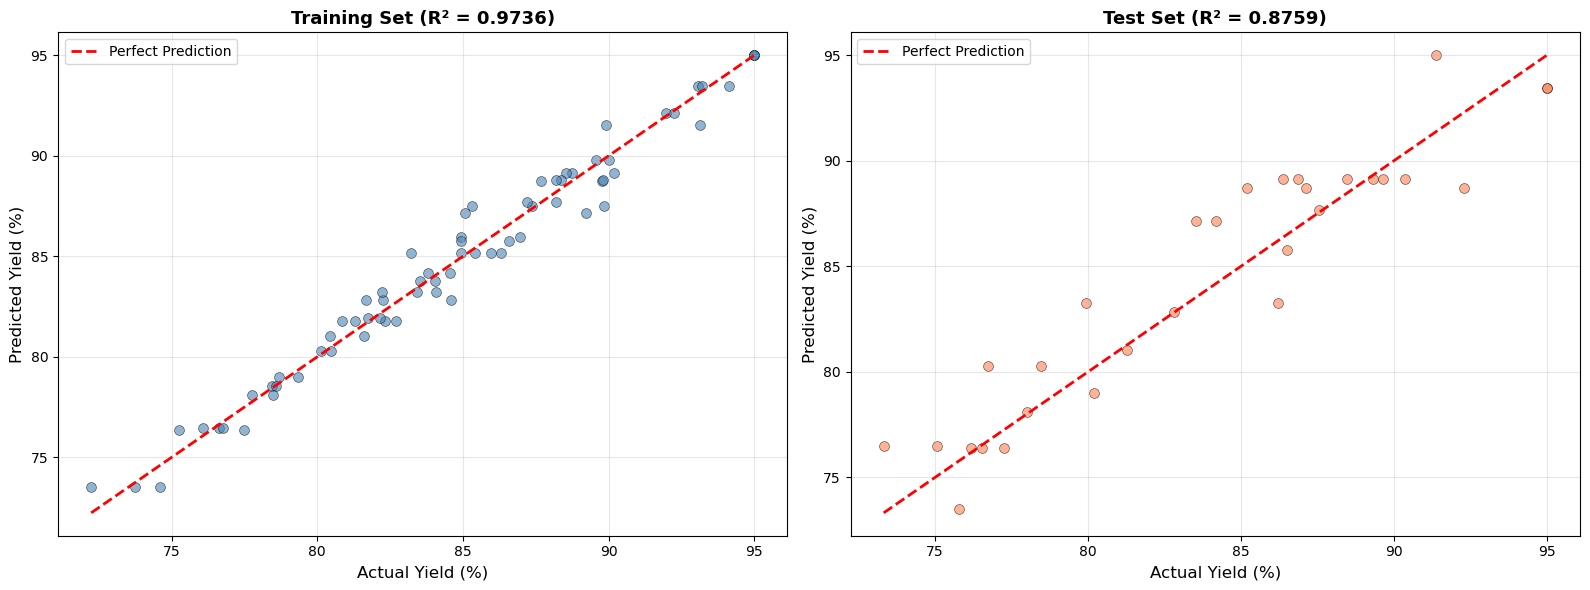

圖 6：預測值 vs 實際值圖已儲存


In [18]:
# 11.1 預測值 vs 實際值
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 訓練集
axes[0].scatter(y_train, y_pred_train_best, alpha=0.6, s=50, color='steelblue', edgecolors='black', linewidth=0.5)
axes[0].plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--', lw=2, label='Perfect Prediction')
axes[0].set_xlabel('Actual Yield (%)', fontsize=12)
axes[0].set_ylabel('Predicted Yield (%)', fontsize=12)
axes[0].set_title(f'Training Set (R² = {train_r2_best:.4f})', fontsize=13, fontweight='bold')
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3)

# 測試集
axes[1].scatter(y_test, y_pred_test_best, alpha=0.6, s=50, color='coral', edgecolors='black', linewidth=0.5)
axes[1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label='Perfect Prediction')
axes[1].set_xlabel('Actual Yield (%)', fontsize=12)
axes[1].set_ylabel('Predicted Yield (%)', fontsize=12)
axes[1].set_title(f'Test Set (R² = {test_r2_best:.4f})', fontsize=13, fontweight='bold')
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(FIG_DIR / '06_predictions_vs_actual.png', dpi=300, bbox_inches='tight')
plt.show()

print("圖 6：預測值 vs 實際值圖已儲存")

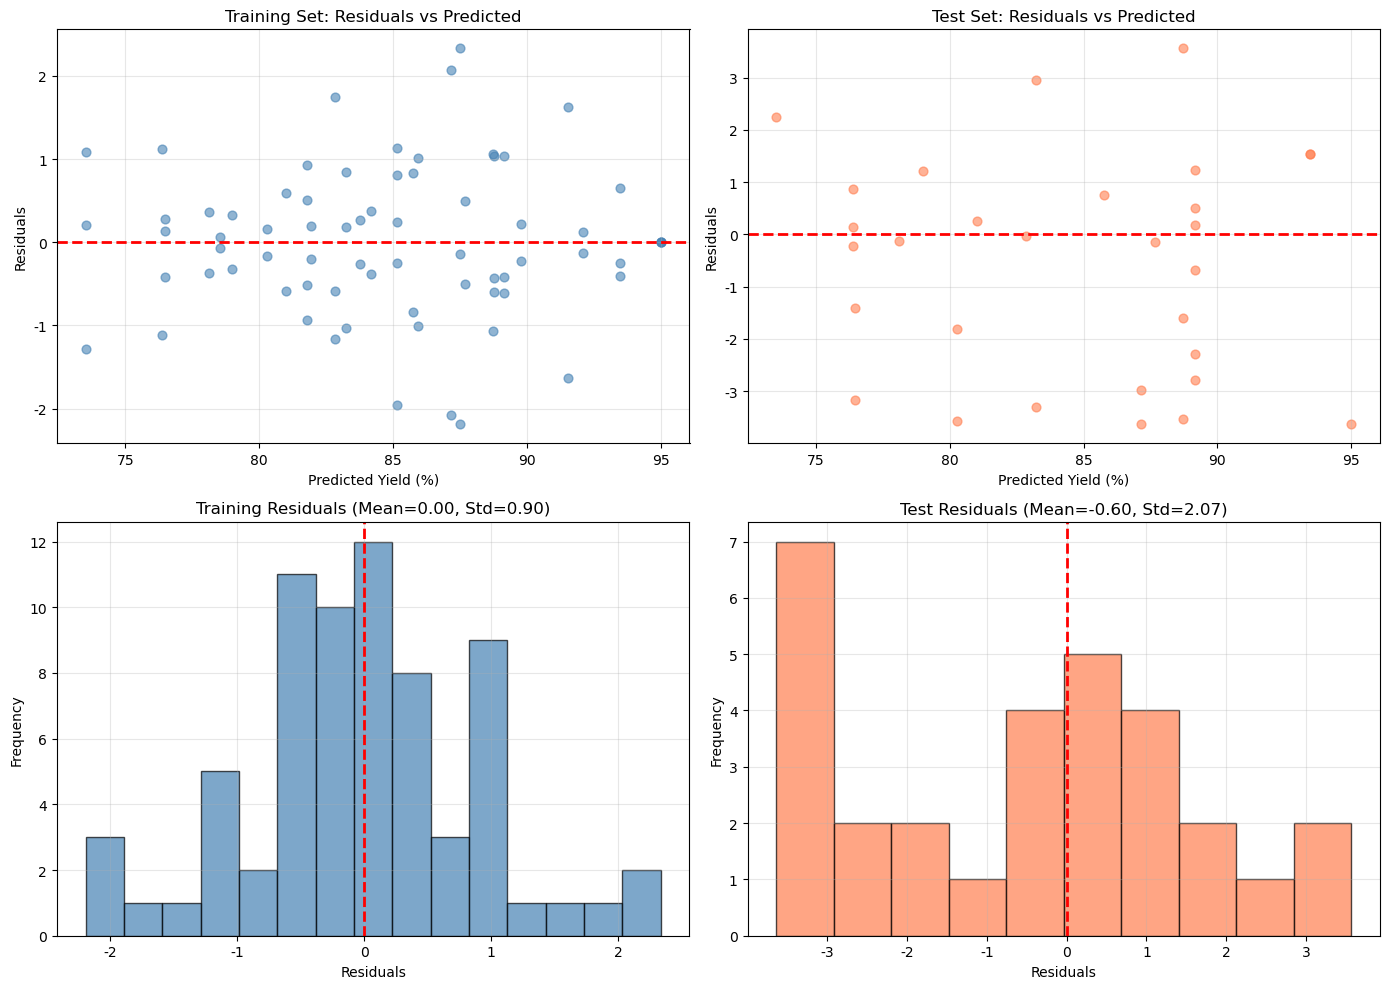

圖 7：殘差分析圖已儲存

測試集殘差統計：
  均值：-0.5980
  標準差：2.0657
  最大值：3.5670
  最小值：-3.6393


In [19]:
# 11.2 殘差分析
residuals_train = y_train - y_pred_train_best
residuals_test = y_test - y_pred_test_best

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 訓練集殘差 vs 預測值
axes[0, 0].scatter(y_pred_train_best, residuals_train, alpha=0.6, s=40, color='steelblue')
axes[0, 0].axhline(y=0, color='red', linestyle='--', linewidth=2)
axes[0, 0].set_xlabel('Predicted Yield (%)')
axes[0, 0].set_ylabel('Residuals')
axes[0, 0].set_title('Training Set: Residuals vs Predicted')
axes[0, 0].grid(True, alpha=0.3)

# 測試集殘差 vs 預測值
axes[0, 1].scatter(y_pred_test_best, residuals_test, alpha=0.6, s=40, color='coral')
axes[0, 1].axhline(y=0, color='red', linestyle='--', linewidth=2)
axes[0, 1].set_xlabel('Predicted Yield (%)')
axes[0, 1].set_ylabel('Residuals')
axes[0, 1].set_title('Test Set: Residuals vs Predicted')
axes[0, 1].grid(True, alpha=0.3)

# 訓練集殘差分佈
axes[1, 0].hist(residuals_train, bins=15, edgecolor='black', alpha=0.7, color='steelblue')
axes[1, 0].axvline(x=0, color='red', linestyle='--', linewidth=2)
axes[1, 0].set_xlabel('Residuals')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].set_title(f'Training Residuals (Mean={residuals_train.mean():.2f}, Std={residuals_train.std():.2f})')
axes[1, 0].grid(True, alpha=0.3)

# 測試集殘差分佈
axes[1, 1].hist(residuals_test, bins=10, edgecolor='black', alpha=0.7, color='coral')
axes[1, 1].axvline(x=0, color='red', linestyle='--', linewidth=2)
axes[1, 1].set_xlabel('Residuals')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].set_title(f'Test Residuals (Mean={residuals_test.mean():.2f}, Std={residuals_test.std():.2f})')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(FIG_DIR / '07_residuals_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("圖 7：殘差分析圖已儲存")
print(f"\n測試集殘差統計：")
print(f"  均值：{residuals_test.mean():.4f}")
print(f"  標準差：{residuals_test.std():.4f}")
print(f"  最大值：{residuals_test.max():.4f}")
print(f"  最小值：{residuals_test.min():.4f}")

## 12. 學習曲線分析

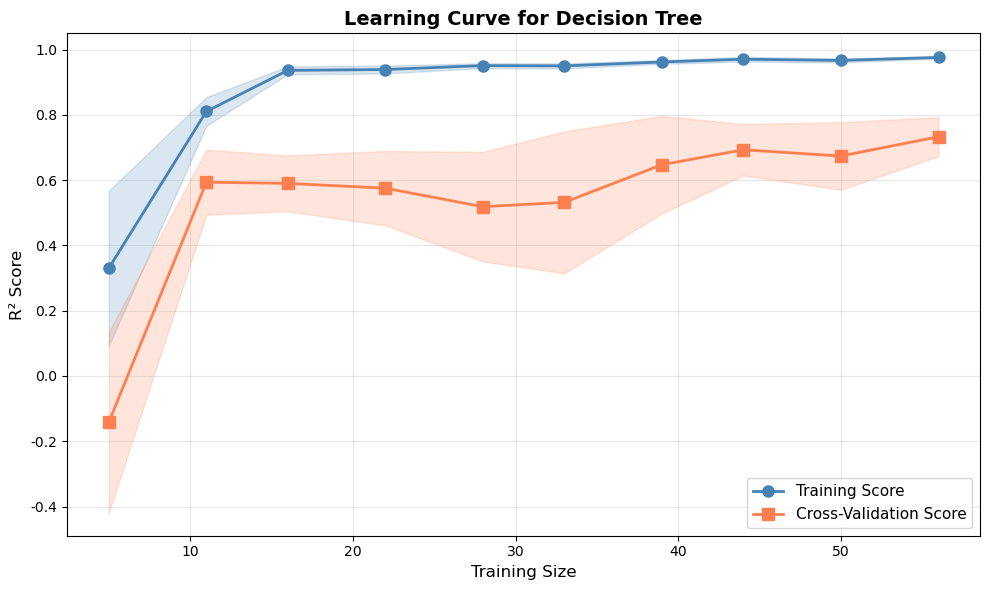

圖 8：學習曲線已儲存


In [20]:
# 計算學習曲線
train_sizes, train_scores, val_scores = learning_curve(
    best_tree,
    X_train, y_train,
    cv=5,
    train_sizes=np.linspace(0.1, 1.0, 10),
    scoring='r2',
    n_jobs=-1
)

# 計算平均和標準差
train_mean = train_scores.mean(axis=1)
train_std = train_scores.std(axis=1)
val_mean = val_scores.mean(axis=1)
val_std = val_scores.std(axis=1)

# 繪圖
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, 'o-', color='steelblue', linewidth=2, markersize=8, label='Training Score')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.2, color='steelblue')
plt.plot(train_sizes, val_mean, 's-', color='coral', linewidth=2, markersize=8, label='Cross-Validation Score')
plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.2, color='coral')

plt.xlabel('Training Size', fontsize=12)
plt.ylabel('R² Score', fontsize=12)
plt.title('Learning Curve for Decision Tree', fontsize=14, fontweight='bold')
plt.legend(loc='best', fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(FIG_DIR / '08_learning_curve.png', dpi=300, bbox_inches='tight')
plt.show()

print("圖 8：學習曲線已儲存")

## 13. 總結與建議

In [21]:
print("="*80)
print("決策樹回歸模型總結")
print("="*80)
print(f"\n✓ 最佳模型參數：")
for param, value in grid_search.best_params_.items():
    print(f"  - {param}: {value}")
print(f"\n✓ 模型複雜度：")
print(f"  - 樹深度：{best_tree.get_depth()}")
print(f"  - 葉節點數：{best_tree.get_n_leaves()}")
print(f"\n✓ 模型性能：")
print(f"  - 測試集 R²：{test_r2_best:.4f}")
print(f"  - 測試集 RMSE：{test_rmse_best:.2f}")
print(f"  - 測試集 MAE：{test_mae_best:.2f}")
print(f"\n✓ 特徵重要性排名：")
for idx, row in feature_importance_df.iterrows():
    print(f"  {idx+1}. {row['Feature']}: {row['Importance']:.3f}")
print(f"\n✓ 最佳操作條件：")
print(f"  - 溫度：{best_condition[0]:.2f}°C")
print(f"  - 壓力：{best_condition[1]:.2f} bar")
print(f"  - 催化劑：{best_condition[2]:.2f} g")
print(f"  - 預測產率：{best_yield:.2f}%")
print("\n" + "="*80)
print("所有結果已儲存至：")
print(f"  - 圖片：{FIG_DIR}")
print(f"  - 數據：{OUTPUT_DIR}")
print("="*80)

決策樹回歸模型總結

✓ 最佳模型參數：
  - max_depth: 7
  - min_samples_leaf: 2
  - min_samples_split: 2

✓ 模型複雜度：
  - 樹深度：7
  - 葉節點數：30

✓ 模型性能：
  - 測試集 R²：0.8759
  - 測試集 RMSE：2.15
  - 測試集 MAE：1.73

✓ 特徵重要性排名：
  1. Temperature: 0.632
  2. Pressure: 0.339
  3. Catalyst: 0.028

✓ 最佳操作條件：
  - 溫度：203.06°C
  - 壓力：4.51 bar
  - 催化劑：0.78 g
  - 預測產率：95.00%

所有結果已儲存至：
  - 圖片：d:\MyGit\CHE-AI-COURSE\Part_3\Unit11\outputs\P3_Unit11_Decision_Tree\figs
  - 數據：d:\MyGit\CHE-AI-COURSE\Part_3\Unit11\outputs\P3_Unit11_Decision_Tree
